## 実行環境の確認

In [1]:
import keras
import tensorflow as tf
import dask

import warnings
warnings.filterwarnings('ignore')

print("keras={}".format(keras.__version__))
print("tensorflow={}".format(tf.__version__))
print("dask={}".format(dask.__version__))

Using TensorFlow backend.


keras=2.2.4
tensorflow=1.13.1
dask=1.1.4


## モジュールのインポート

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

## データの読み込み

In [2]:
import dataset
X,Y = dataset.load_data()

## データの可視化

In [3]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

In [4]:
types = np.array([
        "Normal",
        "Fire",
        "Water",
        "Electric",
        "Grass",
        "Ice",
        "Fighting",
        "Poison",
        "Ground",
        "Flying",
        "Psychic",
        "Bug",
        "Rock",
        "Ghost",
        "Dragon",
        "Dark",
        "Steel",
        "Fairy"
        ])

In [5]:
# 各ラベルごとに画像を10枚格納
img_list = []
for for_1 in range(18):
    choice_idx = np.random.choice(np.where(Y[0] == for_1)[0], 10)
    img_list.append(X[choice_idx])

TypeError: only integer scalar arrays can be converted to a scalar index

In [7]:
# データの可視化
# for for_1 in range(18):
#     fig, ax = plt.subplots(1, 10, figsize=(18, 8))
#     for for_2 in range(10):
#         ax[for_2].imshow(img_list[for_1][for_2].reshape(215, 215, 4))
#         ax[for_2].set_title(types[for_1])
#         ax[for_2].axis('off')

## データの前処理

In [8]:
X = X[:801]
type1 = Y[:801]
type2 = Y[801:]

X_train = X[:721]
y_train1 = type1[:721]
y_train2 = type2[:721]

X_test = X[721:]
y_test1 = type1[721:]
y_test2 = type2[721:]

In [9]:
img_rows, img_cols = 215,215
img_channels = 4

In [10]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [11]:
nb_classes = 18 # 正解のパターン数

In [12]:
from keras.utils import np_utils
# クラスベクトルをバイナリクラスの行列に変換する
Y_train1 = np_utils.to_categorical(y_train1, nb_classes)
Y_train2 = np_utils.to_categorical(y_train2, nb_classes)
Y_test1 = np_utils.to_categorical(y_test1, nb_classes)
Y_test2 = np_utils.to_categorical(y_test2, nb_classes)

In [13]:
# クラスベクトル(ここでは一枚目の正解値は4と7)
print(y_train1[0])
print(y_train2[0])

4
7


In [14]:
# バイナリクラスの行列
print(Y_train1[4])
print(Y_train2[4])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
# backendの違いによる次元数の入力型の調整(おまじない)
from keras import backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

## モデルの構築

In [16]:
from keras.layers import Dropout,Flatten,Conv2D,MaxPooling2D,Conv1D

In [17]:
input_layer = Input(shape=input_shape)

m = Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu")(input_layer)

m = Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu")(m)
m = MaxPooling2D(pool_size=(2,2))(m)
m = Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu")(m)
m = MaxPooling2D(pool_size=(2,2))(m)
m = Flatten()(m)
m = Dense(1024, activation='relu')(m)
m = Dropout(0.5)(m)
output_layer1 = Dense(nb_classes, activation='softmax', name='type1_output')(m)
output_layer2 = Dense(nb_classes, activation='softmax', name='type2_output')(m)

model = Model(inputs=input_layer, outputs=[output_layer1, output_layer2])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 215, 215, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 215, 215, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 107, 107, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 107, 107, 128 73856       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

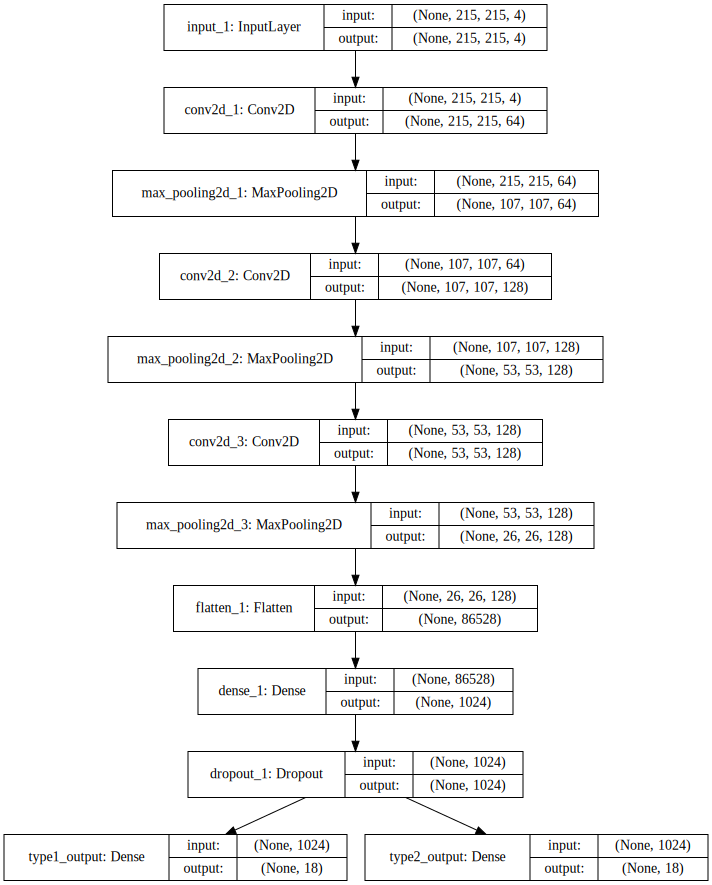

In [19]:
# モデルの可視化
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## モデルの最適化関数や誤差関数を設定

In [20]:
from keras.optimizers import SGD, Adadelta, Adam, RMSprop # 最適化手法

model.compile(loss={"type1_output": "categorical_crossentropy",
                    "type2_output": "categorical_crossentropy",}, # 誤差(損失)関数
              optimizer="Adam", # 最適化関数
              metrics=["accuracy"] # 評価指標
             )

## 学習

In [21]:
import time

In [ ]:
# 学習を実行
# 学習途中の損失関数の値などはhistory.historyに保存される。
history = model.fit(X_train, 
                    {"type1_output": Y_train1, "type2_output": Y_train2},
                    batch_size=64,
                    nb_epoch=5, # 試行回数
                    verbose=1,
                    validation_data=(X_test, {"type1_output": Y_test1, "type2_output": Y_test2}))

Instructions for updating:
Use tf.cast instead.
Train on 721 samples, validate on 80 samples
Epoch 1/5


## 評価

In [ ]:
# テストデータに対する評価値
score = model.evaluate(X_test, [Y_test1,Y_test2], verbose=0)
score
# print('Test score:', score[0]) # 損失関数の値
# print('Test accuracy:', score[1]) # 精度

In [ ]:
# 学習曲線
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['type1_output_loss'], label='type1_output_loss')
ax[0].plot(history.epoch, history.history['type2_output_loss'], label='type2_output_loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].plot(history.epoch, history.history['val_type1_output_loss'], label='val_type1_output_loss')
ax[0].plot(history.epoch, history.history['val_type2_output_loss'], label='val_type2_output_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['type1_output_acc'], label='type1_output_acc')
ax[1].plot(history.epoch, history.history['type2_output_acc'], label='type2_output_acc')
ax[1].plot(history.epoch, history.history['val_type1_output_acc'], label='val_type1_output_acc')
ax[1].plot(history.epoch, history.history['val_type2_output_acc'], label='val_type2_output_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

## 予測の可視化

In [ ]:
# 予測値
New_test = X_test
# 画像のラベルを推定する
Y_test_pred = model.predict(New_test)
Y_test1_pred = Y_test_pred[0]
Y_test2_pred = Y_test_pred[1]

In [ ]:
# データの可視化
# 上段は正しいラベル　下段は推測ラベル
fig, ax = plt.subplots(8, 10, figsize=(18, 18))
for for_1 in range(8):
    for for_2 in range(10):
        ax[for_1][for_2].imshow(New_test[for_1*10+for_2].reshape(215, 215, 4))
        ax[for_1][for_2].set_title(f"{types[y_test1[for_1*10+for_2]]}:{types[y_test2[for_1*10+for_2]]}"
                                   +"\n"
                                   +f"{types[np.argmax(Y_test1_pred[for_1*10+for_2])]}:{types[np.argmax(Y_test2_pred[for_1*10+for_2])]}")
        ax[for_1][for_2].axis('off')

In [ ]:
# 予測の可視化
# Y軸が渡した画像の数字　X軸がニューラルネットワークによる推定値
plt.imshow(Y_test1_pred, cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる

In [ ]:
plt.imshow(Y_test2_pred, cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる